In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
# GPU 설정
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")  # GPU 사용 가능하면 cuda, 없으면 cpu

print(f"현재 사용 중인 디바이스: {device}")
if use_cuda:
    print(f"GPU 정보: {torch.cuda.get_device_name(0)}")

현재 사용 중인 디바이스: cuda
GPU 정보: NVIDIA A100-SXM4-40GB


In [ ]:
# Dataset Path
train_dir = '/content/drive/MyDrive/kaggle/Fruits_and_Vegetables_Image_Recognition/train'
test_dir = '/content/drive/MyDrive/kaggle/Fruits_and_Vegetables_Image_Recognition/test'
valid_dir = '/content/drive/MyDrive/kaggle/Fruits_and_Vegetables_Image_Recognition/validation'

In [ ]:
# png 파일의 이미지 형식이 P모드로 저장되어있어서 경고 메시지가 출력됨 -> png 파일의 확장자를 jpg로 변경
def png_to_jpg(root_dir):
    for class_folder in os.listdir(root_dir):  # 클래스 폴더 순회
        class_path = os.path.join(root_dir, class_folder)

        # 폴더가 아니면 스킵
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # 확장자가 .png인지 확인
            if img_path.lower().endswith(".png"):
                # 이미지 열기
                try:
                    with Image.open(img_path) as img:
                        # RGB로 변환 후 JPG로 저장
                        img = img.convert("RGB")

                        # 새로운 JPG 경로
                        new_img_path = img_path.rsplit(".", 1)[0] + ".jpg"

                        img.save(new_img_path, "JPEG", quality=95)  # 95% 품질 유지
                        print(f"변환 완료: {img_path} → {new_img_path}")

                        # 기존 PNG 삭제
                        os.remove(img_path)

                except Exception as e:
                    print(f"변환 실패: {img_path} - {e}")

# 데이터셋에 변환 적용
png_to_jpg(train_dir)
png_to_jpg(valid_dir)
png_to_jpg(test_dir)

print("PNG → JPG 변환 성공")

PNG → JPG 변환 성공


In [ ]:
# ResNet50에서 사용할 이미지로 변환
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet과 동일한 전처리 방식 사용 (동일한 정규화)
])

In [ ]:
# Dataset Load (ImageNet 전처리 적용)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [ ]:
# DataLoader 설정 / GPU 가속 최적화
# 실행 속도가 조금 느려지면, num_workers의 값을 줄여서 저장 -> 느려져서 4에서 0로 변경
# 실행 속도가 느려진다면, batch_size 값을 줄여서 저장 -> 32에서 16으로 줄임
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
print(f"Train 데이터 개수: {len(train_dataset)}")       # 클래스 당 약 100장
print(f"Validation 데이터 개수: {len(valid_dataset)}")  # 클래스 당 약 10장
print(f"Test 데이터 개수: {len(test_dataset)}")         # 클래스 당 약 10장

Train 데이터 개수: 3115
Validation 데이터 개수: 351
Test 데이터 개수: 359


In [ ]:
# 클래스 라벨 확인
print(f'클래스 개수 : {len(test_dataset.classes)}')
print(f'클래스 목록 : {test_dataset.classes}')

클래스 개수 : 36
클래스 목록 : ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


-----------------
=== ResNet50 ===

    - Fully Connected (FC) Layer 학습 가능하도록 설정
    - Conv Layer의 일부 Layer4만 학습 가능하도록 설정

In [ ]:
# 사전 학습된 ResNet50 불러오기
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# ResNet50의 기본 FC Layer는 1000개 클래스 분류용이므로, 36개에 맞게 새로운 FC Layer를 추가해야 함
# 기존 FC Layer를 새로운 클래스로 변경
# num_classes = len(train_dataset.classes) # 36개

# 일부 모델 커스텀 진행
model.fc = nn.Sequential(
    nn.Linear(2048, 512),           # 기존 출력 크기는 2048
    nn.ReLU(),                      # 활성화 함수
    nn.Dropout(0.3),                # 과적합 방지로 추가 : 0.5에서 0.3으로 변경
    nn.Linear(512, 36)     # 최종 출력 개수를 36개로 변경
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


In [ ]:
# 모든 레이어를 학습 가능하도록 설정
for param in model.parameters():
    param.requires_grad = True

# FC Layer와 Conv Layer의 Layer4만 학습 가능하도록 설정
# 기존 Feature Extractor 방식보다 더 강력한 Fine-Tuning이 가능함
# 가중치가 늘어나서 성능 향상 가능
# 하지만 전체 Conv Layer를 학습시키는 것보다 학습 속도가 빠름
# 사전 학습된 가중치를 유지하면서, 가장 중요한 고차원 특징을 추가적으로 학습 가능 - Layer4
for name, param in model.named_parameters():
    if not name.startswith("layer4") and not name.startswith("fc"):
        param.requires_grad = False

In [ ]:
# 모델 GPU로 이동
model = model.to(device)

In [ ]:
# 손실함수 및 옵티마이저 설정
# 다중 클래스 분류이므로 CrossEntropyLoss 사용
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Conv Layer는 학습하지 않고, FC Layer만 학습하므로 SGD말고 Adam 옵티마이저 사용
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # 추가 성능 향상을 위해서 Adam을 SGD로 변경
# AdamW로 변경 : 학습 속도와 최적화 속도가 더 빨라질 수 있음
# Learning Rate를 줄임 -> 모델이 학습을 잘 하고 있는데 성능이 조금 정체되거나 진동하므로, 학습률을 줄여서 안정적인 수렴이 가능하도록 만듬
# ㄴ 학습률 lr = 0.001 -> 0.0005 -> 0.0001로 줄임
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [ ]:
# 스케줄러 적용
# 스케줄러 : 모델의 성능이 정체되면 자동으로 lr를 줄여주는 방식
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
# ReduceLR0nPlateau를 CosineAnnealingWarmRestarts로 변경 : 보다 부드럽게 학습률을 조절하면서 성능 향상을 유도함
# 매 T_0 epoch마다 학습률이 리셋되며 미세 조정 가능
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

- AMP(GridScaler) 적용
    - torch.cuda.amp.GradScaler() : 스케일링 적용
    - with torch.cuda.amp.autocast() : FP16 연산 활성화
    - scaler.scale(loss).backward() : Gradient Scaling 적용
    - scaler.step(optimizer) -> scaler.update() 실행

In [ ]:
# 경고 메시지 출력 안함
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="PIL.Image")

# 성능 기록을 위한 리스트 초기화 진행
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Early Stopping 기준 변수
best_valid_acc = 0          # 최고의 Validation 정확도를 저장
best_valid_loss = float("inf")
early_stopping_counter = 0
early_stopping_patience = 3  # 3번 연속 성능이 개선되지 않으면 멈춤

epochs = 20
scaler = torch.amp.GradScaler("cuda")  # AMP : Mixed Precision 활성화

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # AMP 적용 (Mixed Precision) : 속도 + 메모리 효율 높임
        with torch.amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # 역전파 수행
        scaler.scale(loss).backward()   # loss 값을 내부적으로 스케일해서 backward() 호출 : 작은 gradient들이 underflow되지 않고 안정적으로 역전파 가능
        scaler.step(optimizer)          # 스케일된 gradient를 기준으로 optimizer step을 수행 : gradient를 스케일된 값으로 클리핑하고, 다시 스케일을 원래대로 복원한 후 파라미터 업데이트를 진행함
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Train Loss 계산
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # Validation 성능 평가
    model.eval()  # 모델을 평가 모드로 전환
    correct, total, val_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:  # Validation Set 사용
            images, labels = images.to(device), labels.to(device)

            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_valid_loss = val_loss / len(valid_loader)
    valid_acc = 100 * correct / total  # Validation 정확도 계산

    # ReduceLR0nPlateau은 Validation Loss를 기준으로 학습률 조정
    # scheduler.step(avg_valid_loss)  # Cosine Annealing 적용
    # CosineAnnealingWarmRestarts에서 사용하는 스케줄러 방식 적용 -> Cosine Annealing은 metric없이 step만 호출
    scheduler.step(epoch + 1)

    # 성능 기록
    train_losses.append(avg_train_loss)
    val_losses.append(avg_valid_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(valid_acc)

    # Early Stopping
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        early_stopping_counter = 0  # 성능 개선되면 카운터 초기화
        best_valid_acc = valid_acc

        # 모델 저장
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stopping_counter += 1  # 성능 개선 안 되면 카운트 증가
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early Stopping. Epoch {epoch+1}에서 학습 종료")
            break

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Valid Loss: {avg_valid_loss:.4f}, "
          f"Train Accuracy: {train_acc:.2f}%, "
          f"Valid Accuracy: {valid_acc:.2f}%, "
          f"Time: {time.time() - start_time:.2f}s")

# 과적합이 아니고, 일시적인 성능 흔들림이 나타남

Epoch [1/20], Train Loss: 2.1518, Valid Loss: 1.0588, Train Accuracy: 54.48%, Valid Accuracy: 88.03%, Time: 958.30s
Epoch [2/20], Train Loss: 1.1991, Valid Loss: 0.9729, Train Accuracy: 82.12%, Valid Accuracy: 91.45%, Time: 131.61s
Epoch [3/20], Train Loss: 1.0047, Valid Loss: 0.8908, Train Accuracy: 89.66%, Valid Accuracy: 96.01%, Time: 131.31s
Epoch [4/20], Train Loss: 0.8850, Valid Loss: 0.8579, Train Accuracy: 94.35%, Valid Accuracy: 95.44%, Time: 132.06s
Epoch [5/20], Train Loss: 0.8336, Valid Loss: 0.8460, Train Accuracy: 96.37%, Valid Accuracy: 96.01%, Time: 132.22s
Epoch [6/20], Train Loss: 0.9086, Valid Loss: 0.8789, Train Accuracy: 93.26%, Valid Accuracy: 95.44%, Time: 132.04s
Epoch [7/20], Train Loss: 0.8857, Valid Loss: 0.8352, Train Accuracy: 94.83%, Valid Accuracy: 96.87%, Time: 131.99s
Epoch [8/20], Train Loss: 0.8230, Valid Loss: 0.8328, Train Accuracy: 96.73%, Valid Accuracy: 96.87%, Time: 132.09s
Epoch [9/20], Train Loss: 0.7917, Valid Loss: 0.7933, Train Accuracy: 97

- 과적합이 난 것으로 보이지만, early stopping을 사용하여 best_model.pth는 가장 성능이 좋은 시점(epoch14)의 모델로 저장되어 있음.

-- 전혀 과적합이 아니라 모델이 잘 수렴중임을 알 수 있음 --

1.   Train Loss와 Valid Loss 모두 대체로 안정적으로 줄어들고 있음
2.   중간중간 Valid Loss가 살짝 올랐다가도 다시 내려감 (정상적인 패턴)
3. Validation Accuracy도 점진적으로 올라감
4. Train Acc가 Valid Acc보다 훨씬 높아지는 현상도 없음 -> 과적합 아님



In [ ]:
# 일시적으로 GPU의 모델을 구글 드라이브에 저장하여 다음에 다시 불러와서 사용함
import shutil

# Colab의 현재 작업 디렉토리에서 구글 드라이브로 복사
shutil.copy("best_model.pth", "/content/drive/MyDrive/kaggle/best_model.pth")

In [ ]:
# 정상적으로 복사되었는지 확인 필요
import os

print(os.path.exists("/content/drive/MyDrive/kaggle/best_model.pth"))  # True이면 복사 완료

True


In [ ]:
# 파일이 정상적으로 저장이 되었는지 확인 필요
import pickle

save_path = "/content/drive/MyDrive/kaggle/performance_data.pkl"

performance_data = {
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'train_losses': train_losses,
    'val_losses': val_losses
}

with open(save_path, 'wb') as f:
    pickle.dump(performance_data, f)

print("성능 기록 저장 완료")

성능 기록 저장 완료!


In [ ]:
# 다시 런타임을 연결하여 사용할 때, 파일을 불러와서 사용해야함.
import pickle

load_path = "/content/drive/MyDrive/kaggle/performance_data.pkl"

with open(load_path, 'rb') as f:
    data = pickle.load(f)

# 다시 변수에 할당
train_accuracies = data['train_accuracies']
val_accuracies = data['val_accuracies']
train_losses = data['train_losses']
val_losses = data['val_losses']

print("성능 기록 불러오기 완료")

성능 기록 불러오기 완료!


In [ ]:
# best_model.pth를 원하는 경로에 저장
torch.save(model.state_dict(), "/content/drive/MyDrive/kaggle/best_model.pth")

In [ ]:
# 모델 구조 정의 먼저 해야 함 (model = resnet50(...) 같은 코드 먼저 실행 후 이번 코드 실행)
# 구글 드라이브에서 모델을 가져오는 경우 실행
model.load_state_dict(torch.load("/content/drive/MyDrive/kaggle/best_model.pth"))
model.to(device)
model.eval()

In [ ]:
# GPU에서 해당 모델 불러와서 사용하는 경우 실행
# 저장된 모델 불러오기
model.load_state_dict(torch.load("best_model.pth"))

# 모델 GPU로 이동
model.to(device)

# 모델 평가
model.eval()

In [ ]:
# test dataset 예측 결과 저장
all_preds = []
all_labels = []

correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 리스트에 예측 결과 저장
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"테스트 정확도: {100 * correct / total:.2f}%")

테스트 정확도: 97.49%


- 95%를 넘기면 거의 최적화된 상태
- Validation과 Test 정확도가 비슷한 것도 중요함
    - 과적합의 문제가 거의 없다는 것을 의미
    > 모델이 잘 일반화 된 것으로 평가

-----------------
=== 학습 시각화 ===


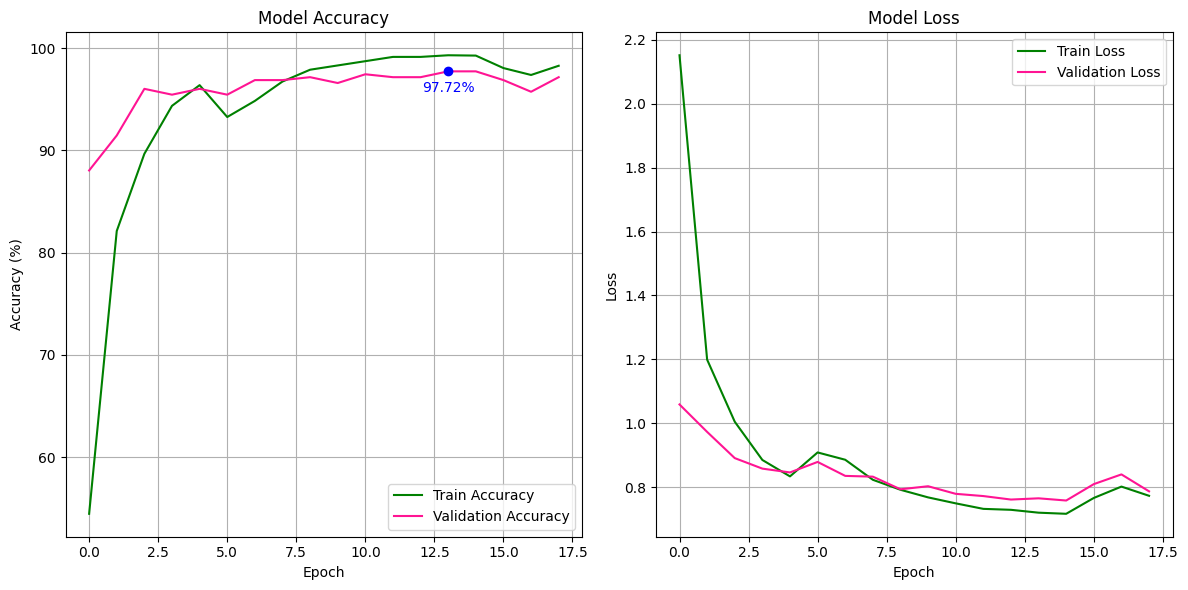

In [ ]:
# best 모델이 저장된 epoch index (Validation Accuracy 기준)
best_epoch = val_accuracies.index(max(val_accuracies))
best_val_acc = val_accuracies[best_epoch]

# 가로 창 띄우기
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='deeppink')

# 최고 성능 epoch의 점을 plot으로 표시 (marker 사용)
plt.plot(best_epoch, best_val_acc, marker='o', color='blue')

# 텍스트 추가
plt.text(best_epoch, best_val_acc - 2 , f'{best_val_acc:.2f}%',
          color='blue', ha='center', fontsize=10)

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(val_losses, label='Validation Loss', color='deeppink')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 오류 방지를 위한 클래스 범위 확인
print("예측값 클래스 범위:", min(all_preds), "~", max(all_preds))
print("정답값 클래스 범위:", min(all_labels), "~", max(all_labels))
print("클래스 총 개수 (예측 기준):", len(set(all_preds)))
print("클래스 총 개수 (정답 기준):", len(set(all_labels)))

예측값 클래스 범위: 0 ~ 35
정답값 클래스 범위: 0 ~ 35
클래스 총 개수 (예측 기준): 36
클래스 총 개수 (정답 기준): 36


               precision    recall  f1-score   support

        apple       0.82      0.90      0.86        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      0.90      0.95        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.91      1.00      0.95        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00        10
         corn       0.83      1.00      0.91        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00        10
     jalepeno       1.00      1.00      1.00        10
         kiwi       1.00      1.00      1.00        10
        l

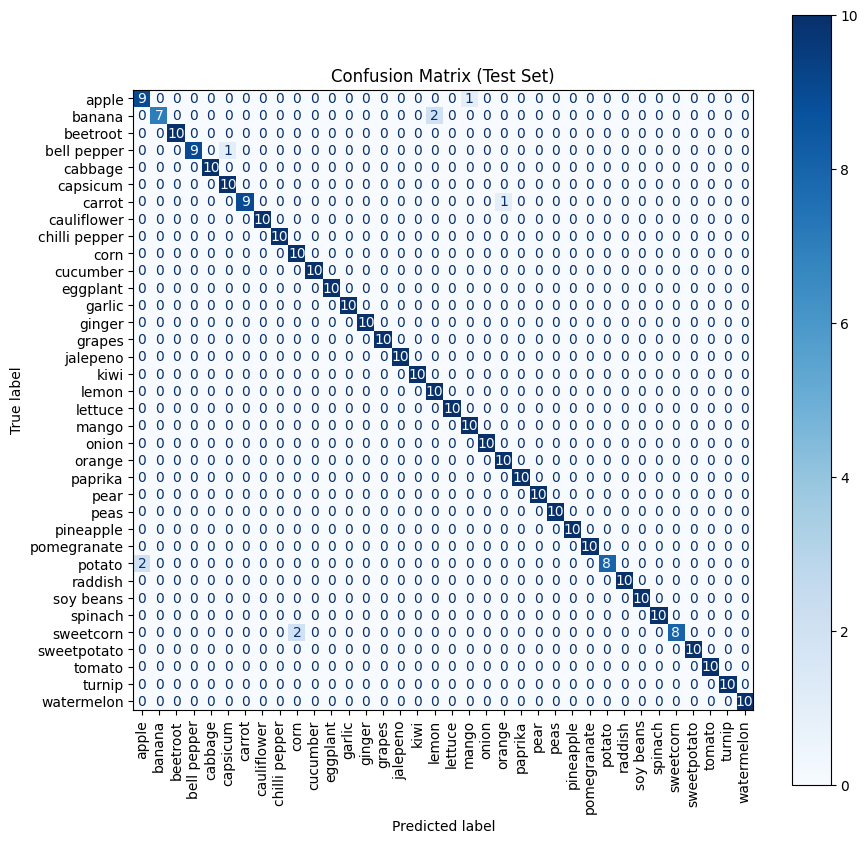

In [ ]:
# Test Dataset Confusion Matrix 시각화
cm = confusion_matrix(all_labels, all_preds)
class_names = test_loader.dataset.classes

# classification report 출력
print(classification_report(all_labels, all_preds, target_names=class_names))

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.show()

-------------------
=== 추가 데이터 입력 테스트 진행 ===

    - 실제 데이터를 입력해 예측 또는 분류 결과 출력

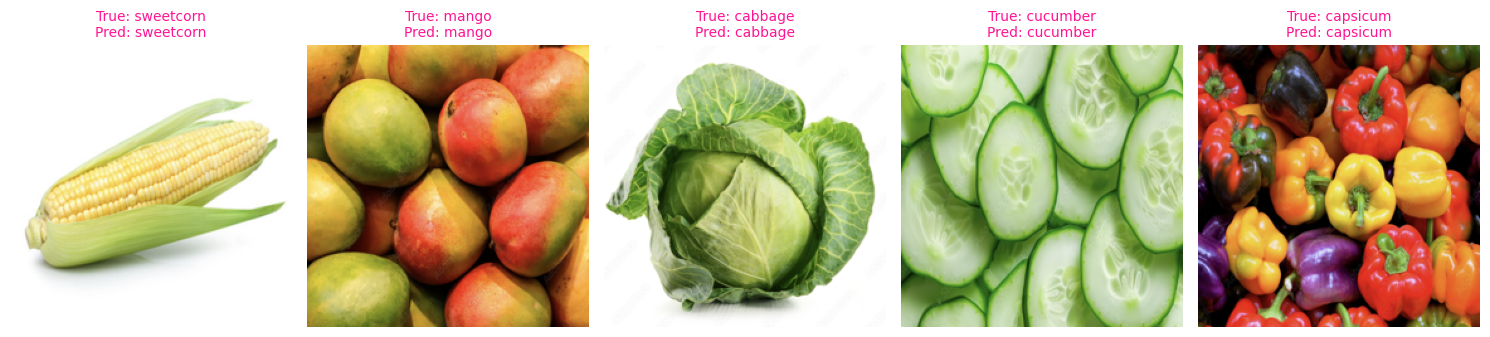

In [ ]:
import torch.nn.functional as F

# 이미지 경로 리스트
img_paths = [
    "/content/drive/MyDrive/kaggle/sweetcorn.png",
    "/content/drive/MyDrive/kaggle/mango.png",
    "/content/drive/MyDrive/kaggle/cabbage.png",
    "/content/drive/MyDrive/kaggle/cucumber.png",
    "/content/drive/MyDrive/kaggle/capsicum.png"
]

# 모델 예측 및 시각화
model.eval()

class_names = test_loader.dataset.classes

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i, img_path in enumerate(img_paths):
    true_label = os.path.basename(img_path).split('.')[0].lower()

    # 이미지 불러오기 및 resize : 시각화용 이미지도 224x224로 맞춤
    img = Image.open(img_path).convert("RGB").resize((224, 224))
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        pred_idx = probs.argmax(dim=1).item()

    predicted_label = class_names[pred_idx]
    title_color = 'deeppink' if true_label == predicted_label else 'royalblue'

    # 이미지 출력
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10, color=title_color)

plt.tight_layout()
plt.show()

--------------
=== DB 연동 ===

- SQLite에서 직접 MySQL로 마이그레이션

        앞서 구글 드라이브에 저장한 performance_data.pkl 파일을 DB에 저장하는 방식으로 진행하면 좋을 것 같다.  
        train, valid 데이터에 대한 accuracy와 loss 값을 저장하여 관리할 수 있다.  

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sqlite3
import pickle

In [ ]:
# pickle 파일 로드
with open("/content/drive/MyDrive/kaggle/performance_data.pkl", 'rb') as f:
    performance_data = pickle.load(f)

In [ ]:
# SQLite DB 연결 (없으면 자동 생성됨)
conn = sqlite3.connect('/content/drive/MyDrive/kaggle/model_metrics.db')
cursor = conn.cursor()

In [ ]:
# 테이블 생성
cursor.execute('''
    CREATE TABLE IF NOT EXISTS performance (
        epoch INTEGER PRIMARY KEY,
        train_accuracy REAL,
        val_accuracy REAL,
        train_loss REAL,
        val_loss REAL
    )
''')

In [ ]:
# 데이터 삽입
for epoch in range(len(performance_data['train_accuracies'])):
    cursor.execute('''
        INSERT INTO performance (epoch, train_accuracy, val_accuracy, train_loss, val_loss)
        VALUES (?, ?, ?, ?, ?)
    ''', (
        epoch + 1,
        performance_data['train_accuracies'][epoch],
        performance_data['val_accuracies'][epoch],
        performance_data['train_losses'][epoch],
        performance_data['val_losses'][epoch]
    ))


In [ ]:
# 저장 및 종료
conn.commit()
conn.close()
print("성능 데이터 DB에 저장 완료")

📊 성능 데이터 DB에 저장 완료!


In [17]:
conn = sqlite3.connect('/content/drive/MyDrive/kaggle/model_metrics.db')
cursor = conn.cursor()

# 테이블 목록 확인
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("생성된 테이블 목록:")
for table in tables:
    print(" -", table[0])

# performance 테이블 구조 확인
cursor.execute("PRAGMA table_info(performance);")
columns = cursor.fetchall()

print("\n테이블 구조:")
for col in columns:
    print(f" - Column: {col[1]} | Type: {col[2]}")

생성된 테이블 목록:
 - performance

테이블 구조:
 - Column: epoch | Type: INTEGER
 - Column: train_accuracy | Type: REAL
 - Column: val_accuracy | Type: REAL
 - Column: train_loss | Type: REAL
 - Column: val_loss | Type: REAL


In [19]:
cursor.execute("SELECT * FROM performance;")
rows = cursor.fetchall()

print("저장된 데이터:")
for row in rows:
    print(row)


저장된 데이터:
(1, 54.47833065810594, 88.03418803418803, 2.151753524633554, 1.0587957067923113)
(2, 82.11878009630819, 91.45299145299145, 1.1991165185586, 0.9728676351633939)
(3, 89.66292134831461, 96.01139601139602, 1.0047374178201725, 0.8908318172801625)
(4, 94.34991974317818, 95.44159544159544, 0.8850136078321017, 0.8579314351081848)
(5, 96.37239165329053, 96.01139601139602, 0.8336357361231095, 0.8459914164109663)
(6, 93.25842696629213, 95.44159544159544, 0.9085827858020098, 0.8788693709806963)
(7, 94.8314606741573, 96.86609686609687, 0.8857054037925525, 0.8351851620457389)
(8, 96.72552166934189, 96.86609686609687, 0.8229895741511614, 0.8327939429066398)
(9, 97.88121990369181, 97.15099715099716, 0.7917162488668393, 0.7932811704548922)
(10, 98.29855537720707, 96.58119658119658, 0.7678831635377346, 0.8027781817046079)
(11, 98.71589085072232, 97.43589743589743, 0.7492248550439492, 0.779024289412932)
(12, 99.13322632423755, 97.15099715099716, 0.7319671957920759, 0.7720382294871591)
(13, 99.1

In [20]:
import pandas as pd

df = pd.read_sql("SELECT * FROM performance", sqlite3.connect('/content/drive/MyDrive/kaggle/model_metrics.db'))
df

,epoch,train_accuracy,val_accuracy,train_loss,val_loss
0,1,54.478331,88.034188,2.151754,1.058796
1,2,82.118780,91.452991,1.199117,0.972868
2,3,89.662921,96.011396,1.004737,0.890832
3,4,94.349920,95.441595,0.885014,0.857931
4,5,96.372392,96.011396,0.833636,0.845991
5,6,93.258427,95.441595,0.908583,0.878869
6,7,94.831461,96.866097,0.885705,0.835185
7,8,96.725522,96.866097,0.822990,0.832794
8,9,97.881220,97.150997,0.791716,0.793281
9,10,98.298555,96.581197,0.767883,0.802778
